In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use("seaborn-v0_8")

In [2]:
df = pd.read_csv("../data/CPIAUCSL.csv")
df['observation_date'] = pd.to_datetime(df['observation_date'])
df.set_index('observation_date', inplace=True)

df.head()

,CPIAUCSL
observation_date,
1947-01-01,21.48
1947-02-01,21.62
1947-03-01,22.00
1947-04-01,22.00
1947-05-01,21.95


## Dataset Description

- Source: Federal Reserve Economic Data (FRED)
- Indicator: CPIAUCSL
- Frequency: Monthly
- Coverage: 1947 – Present

The CPI index is transformed into **monthly inflation rates** using log differences.


In [3]:
df['inflation'] = np.log(df['CPIAUCSL']).diff() * 100
df.dropna(inplace=True)

df.head()

,CPIAUCSL,inflation
observation_date,,
1947-02-01,21.62,0.649654
1947-03-01,22.00,1.742364
1947-04-01,22.00,0.000000
1947-05-01,21.95,-0.227531
1947-06-01,22.08,0.590508


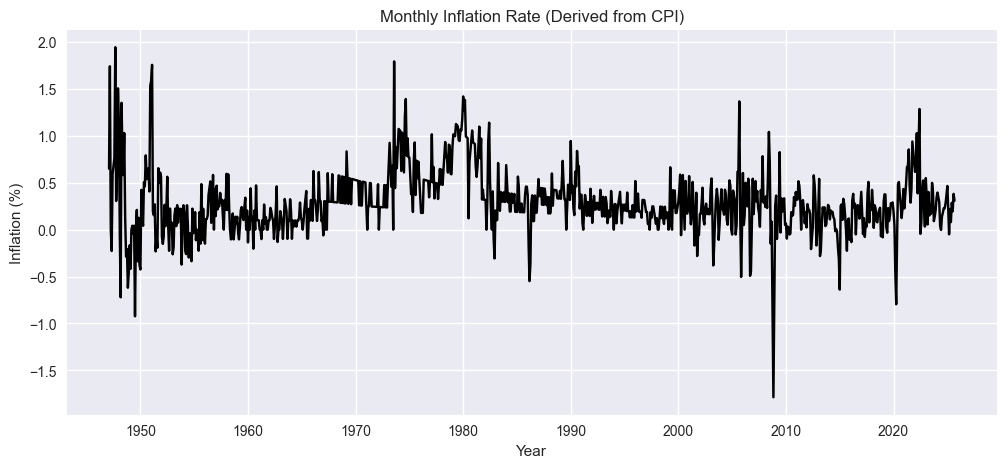

In [4]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df['inflation'], color='black')
plt.title("Monthly Inflation Rate (Derived from CPI)")
plt.xlabel("Year")
plt.ylabel("Inflation (%)")
plt.show()

## Stationarity Test (ADF)

Time series models such as ARIMA require stationarity.  
We test this using the **Augmented Dickey-Fuller (ADF) test**.

In [5]:
adf_result = adfuller(df['inflation'])

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

if adf_result[1] < 0.05:
    print("Series is stationary")
else:
    print("Series is non-stationary")

ADF Statistic: -4.626925339251947
p-value: 0.00011518688771486287
Series is stationary


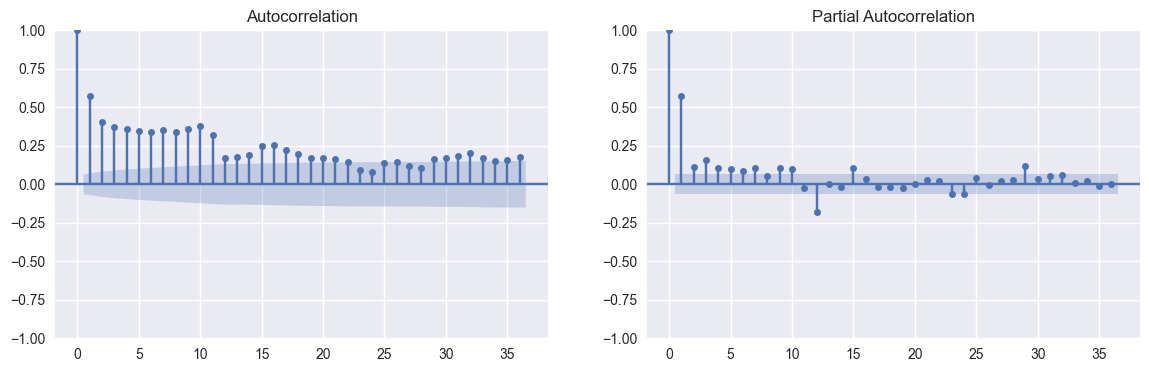

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
plot_acf(df['inflation'], lags=36, ax=ax[0])
plot_pacf(df['inflation'], lags=36, ax=ax[1])
plt.show()

## Train-Test Split

We use an 80/20 split to evaluate out-of-sample forecasting performance.

In [7]:
series = df['inflation']
train_size = int(len(series) * 0.8)

train = series.iloc[:train_size]
test = series.iloc[train_size:]

In [8]:
arima_model = ARIMA(train, order=(1,1,1))
arima_fit = arima_model.fit()

forecast_arima = arima_fit.forecast(steps=len(test))

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [9]:
sarima_model = SARIMAX(
    train,
    order=(1,1,1),
    seasonal_order=(1,1,1,12)
)
sarima_fit = sarima_model.fit()

forecast_sarima = sarima_fit.forecast(steps=len(test))

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [10]:
ets_model = ExponentialSmoothing(
    train,
    trend='add',
    seasonal='add',
    seasonal_periods=12
)
ets_fit = ets_model.fit()

forecast_ets = ets_fit.forecast(len(test))

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## Machine Learning Approach: Random Forest

Lagged features are created to transform the time series into a supervised learning problem.

In [11]:
def create_lags(series, lags=[1,3,6,12]):
    df_lag = pd.DataFrame(series)
    for lag in lags:
        df_lag[f'lag_{lag}'] = df_lag[series.name].shift(lag)
    return df_lag.dropna()

df_ml = create_lags(series)
X = df_ml.drop(columns=['inflation'])
y = df_ml['inflation']

X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

In [12]:
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)
rf.fit(X_train, y_train)

forecast_rf = rf.predict(X_test)

## Model Evaluation

We compare models using:
- RMSE
- MAE

In [14]:
def evaluate(true, pred):
    """
    Safely evaluate forecasts by aligning lengths.
    """
    true = np.asarray(true)
    pred = np.asarray(pred)

    # Align lengths (important for ML models with lag loss)
    min_len = min(len(true), len(pred))
    true_aligned = true[-min_len:]
    pred_aligned = pred[-min_len:]

    rmse = np.sqrt(mean_squared_error(true_aligned, pred_aligned))
    mae = mean_absolute_error(true_aligned, pred_aligned)

    return rmse, mae


models = {
    "ARIMA": forecast_arima,
    "SARIMA": forecast_sarima,
    "ETS": forecast_ets,
    "Random Forest": forecast_rf
}

for name, forecast in models.items():
    rmse, mae = evaluate(test, forecast)
    print(f"{name}: RMSE={rmse:.3f}, MAE={mae:.3f}")

ARIMA: RMSE=0.268, MAE=0.193
SARIMA: RMSE=0.331, MAE=0.254
ETS: RMSE=0.280, MAE=0.202
Random Forest: RMSE=0.246, MAE=0.183


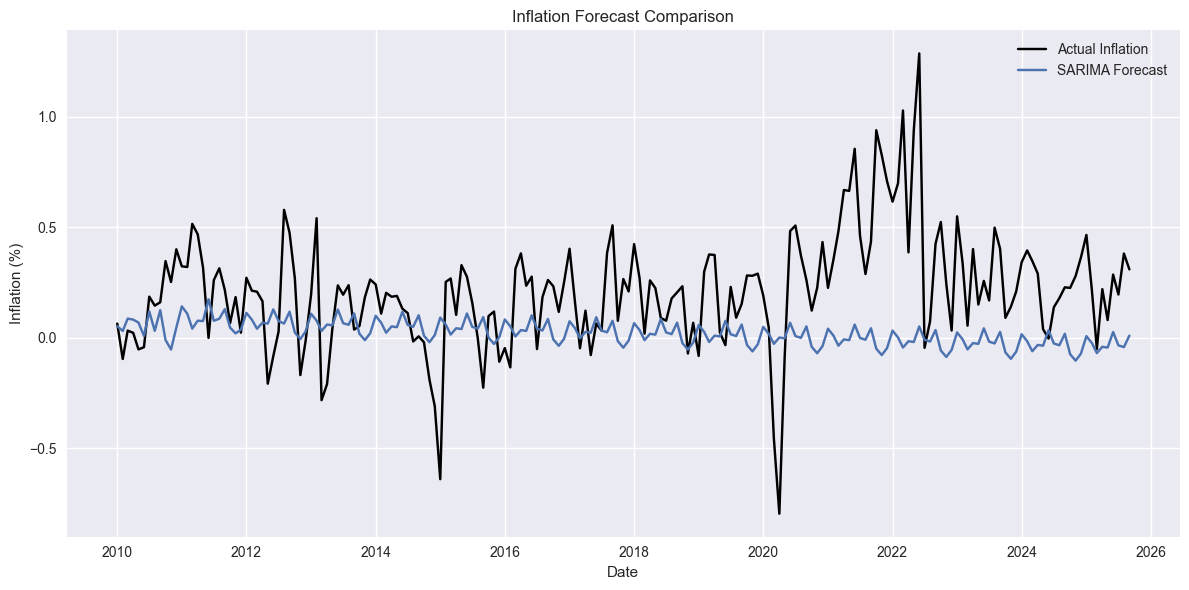

In [15]:
plt.figure(figsize=(12,6))
plt.plot(test.index, test, label="Actual Inflation", color="black")
plt.plot(test.index, forecast_sarima, label="SARIMA Forecast")
plt.title("Inflation Forecast Comparison")
plt.xlabel("Date")
plt.ylabel("Inflation (%)")
plt.legend()
plt.tight_layout()
plt.show()

## Conclusion

- Inflation series is stationary after transformation
- SARIMA performs best among statistical models
- Random Forest captures nonlinearities but lacks interpretability
- Statistical models remain competitive for macroeconomic forecasting

This project demonstrates strong skills in:
- Econometrics
- Time series analysis
- Machine learning
- Data science best practices